In [444]:
import pandas as pd
import numpy as np
from sklearn import tree, metrics, ensemble
import missingno as msno
import matplotlib.pyplot as plt

In [7]:
titanic = pd.read_csv('/home/ahrzb/.kaggle/competitions/titanic/titanic.csv', index_col='PassengerId')

### Empirical Risk Minimization

![](images/erm.png)

### Bias/Variance Trade Off

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/91/Radial_basis_function_fit%2C_spread%3D5.png/800px-Radial_basis_function_fit%2C_spread%3D5.png)
![](images/bvt.png)
![](images/bias.png)
![](images/variance.png)

### Overfitting

![](https://upload.wikimedia.org/wikipedia/commons/6/68/Overfitted_Data.png)

![](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1f/Overfitting_svg.svg/800px-Overfitting_svg.svg.png)

### A little bit more pandas

#### pd.melt, pd.crosstab, pd.pivot_table

In [23]:
pd.melt(
    titanic.reset_index(), 
    id_vars=['PassengerId', 'Survived'], 
    value_vars=['Sex', 'Age']
).head()

,PassengerId,Survived,variable,value
0,1,0,Sex,male
1,2,1,Sex,female
2,3,1,Sex,female
3,4,1,Sex,female
4,5,0,Sex,male


#### DataFrameGroupBy.transform

In [52]:
titanic.groupby('Pclass').Fare.transform('mean').head()

PassengerId
1    13.675550
2    84.154687
3    13.675550
4    84.154687
5    13.675550
Name: Fare, dtype: float64

### Classification

* accuracy
* precision/recall
* tp/np/fp/fn
* imbalanced data

In [64]:
df = titanic.select_dtypes(exclude=['O']).dropna()
X = df.drop('Survived', axis=1)
Y = df.Survived

In [65]:
clf = tree.DecisionTreeClassifier()
clf.fit(X, Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [72]:
metrics.recall_score(Y, clf.predict(X))

0.9517241379310345

### Regression

* r2 score
* interpretation of sum of squares
* skewness
* qqplots

![](images/r2.png)

In [304]:
from sklearn.model_selection import train_test_split
news = pd.read_csv('data/OnlineNewsPopularity.csv', index_col='url')
news.columns = [c.strip() for c in news.columns]
news['shares'] = np.log(news.shares)
news_train, news_test  = train_test_split(news, train_size=30000, random_state=42)
news_train, news_valid = train_test_split(news_train, train_size=25000, random_state=42)

/home/ahrzb/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [324]:
reg = tree.DecisionTreeRegressor(max_depth=5, min_samples_split=21)
reg.fit(news_train.drop('shares', axis=1), news_train.shares)
print(metrics.r2_score(news_valid.shares, reg.predict(news_valid.drop('shares', axis=1))))

0.11314476646693084


### More on imputation

In [150]:
titanic = pd.read_csv(
    '/home/ahrzb/.kaggle/competitions/titanic/train.csv', 
    index_col='PassengerId'
)

train, test = train_test_split(
    titanic, 
    train_size=0.8, 
    random_state=42
)
train, val = train_test_split(
    train, 
    train_size=0.9,
    random_state=42
)

In [300]:
def transform(df):
    df = df.assign(CabinI=df.Cabin.str.extract(r'(\w)\d+').fillna('Other').astype('category'))
    df = df.assign(Title=df.Name.str.extract(r' (\w+)\.'))
    df = df.assign(FamilySize=df.SibSp + df.Parch + 1)
    df = df.assign(
        Title=df.Title.map({
            'Mr': 'Mr',
            'Miss': 'Miss',
            'Mrs': 'Mrs',
            'Master': 'Other',
            'Dr': 'Other',
            'Rev': 'Other',
            'Mlle': 'Other',
            'Major': 'Other',
            'Col': 'Other',
            'Lady': 'Other',
            'Mme': 'Other',
            'Ms': 'Other',
            'Countess': 'Other',
            'Capt': 'Other'
        }).fillna('NoTitle')
    )
    df = df.drop(['Name', 'Sex', 'Age', 'Ticket', 'Cabin'], axis='columns')
    df = df.assign(CabinI=df.CabinI.astype('category').cat.codes)
    df = df.assign(Embarked=df.Embarked.astype('category').cat.codes)
    df = df.assign(Title=df.Title.astype('category').cat.codes)
    return df.drop('Survived', axis='columns'), df.Survived

In [228]:
train_x, train_y = transform(train)
val_x, val_y = transform(val)
test_x, test_y = transform(test)

In [294]:
train_cleaned = transform(train)

In [339]:
train_cleaned.Age.head()

PassengerId
387     1.0
869     NaN
724    50.0
663    47.0
766    51.0
Name: Age, dtype: float64

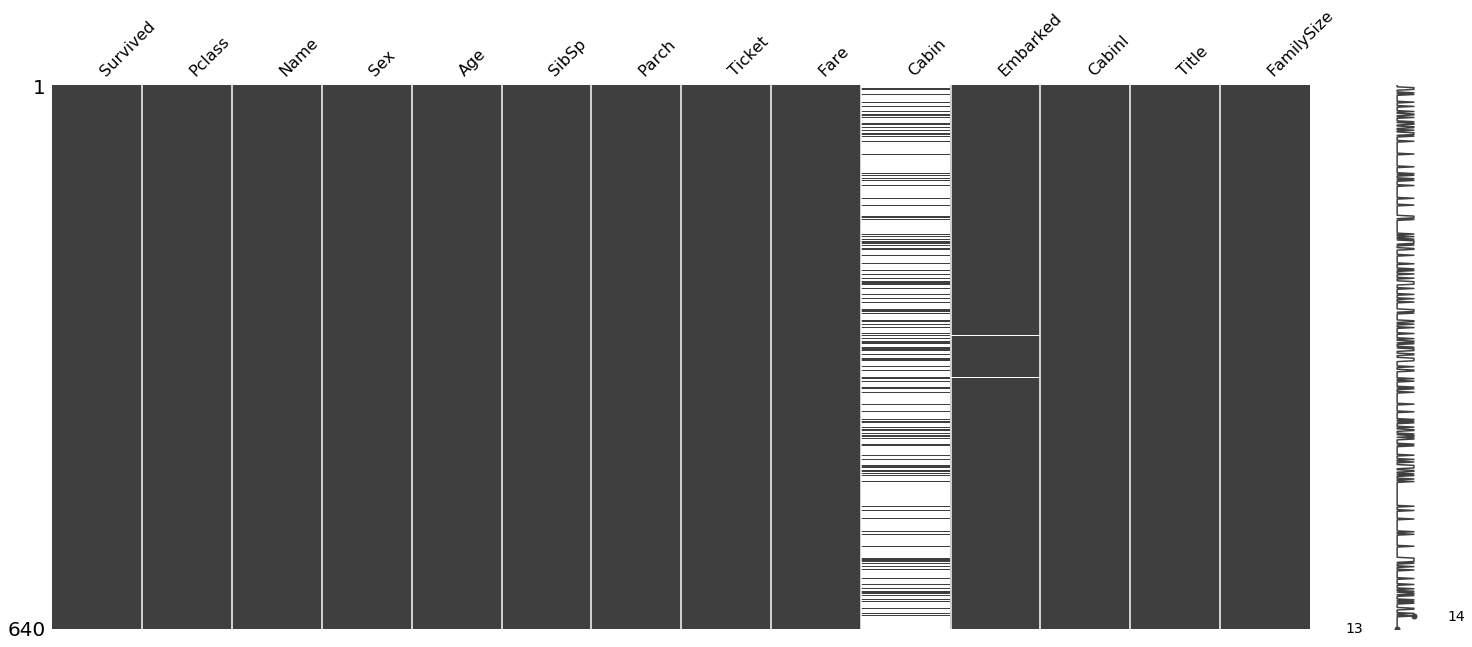

In [348]:
msno.matrix(df)

In [381]:
from sklearn import neighbors

In [389]:
reg = neighbors.KNeighborsRegressor()
df = train_cleaned[~train_cleaned.Age.isna()]
reg.fit(df[['Fare', 'Parch', 'SibSp']], df['Age'])

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

In [394]:
ages = train_cleaned.groupby('SibSp').Age.transform('median')
df = train_cleaned.assign(Age=train_cleaned.Age.fillna(ages).fillna(train_cleaned.Age.median()))
sibsp_age_imp = df.Age

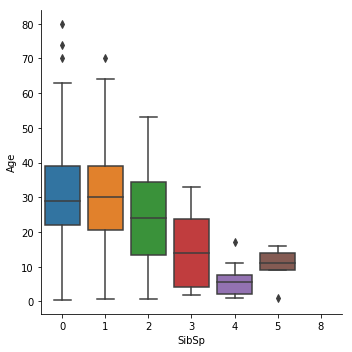

In [328]:
sns.catplot(data=train_cleaned, x='SibSp', y='Age', kind='box')

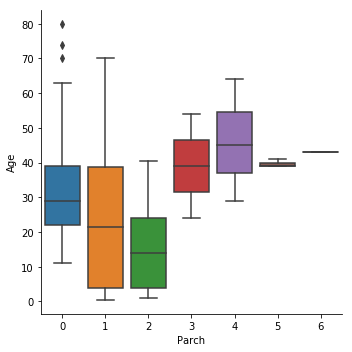

In [391]:
sns.catplot(data=train_cleaned, x='Parch', y='Age', kind='box')

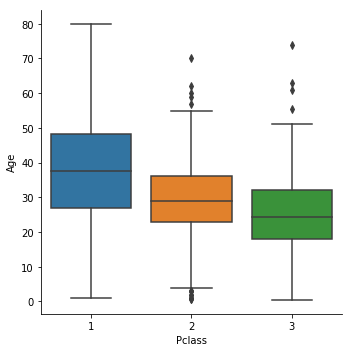

In [392]:
sns.catplot(data=train_cleaned, x='Pclass', y='Age', kind='box')

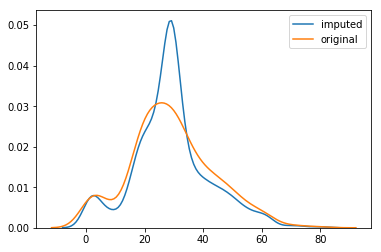

In [398]:
sns.kdeplot(sibsp_age_imp, label='imputed')
sns.kdeplot(train_cleaned.Age, label='original')

In [408]:
'Parch', 'SibSp', 'Pclass'

('Parch', 'SibSp', 'Pclass')

### How much data do I need?

* Learning curves

In [438]:
from sklearn.model_selection import learning_curve

In [467]:
train_sizes, train_scores, val_scores = learning_curve(
    tree.DecisionTreeClassifier(max_depth=4), 
    train_x, train_y, 
    train_sizes=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 400],
    cv=20
)

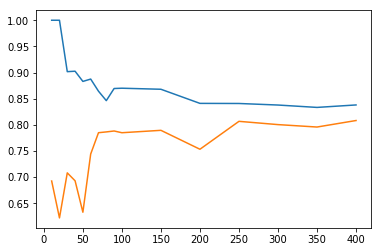

In [472]:
plt.plot(train_sizes, train_scores.mean(axis=1))
plt.plot(train_sizes, val_scores.mean(axis=1))

### Ensemble Methods

* bagging/pasting

In [473]:
from sklearn import ensemble

In [497]:
clf = ensemble.RandomForestClassifier(n_estimators=1000, n_jobs=-1, max_features='log2')
clf.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [498]:
metrics.accuracy_score(val_y, clf.predict(val_x))

0.8333333333333334

In [499]:
metrics.accuracy_score(test_y, clf.predict(test_x))

0.8268156424581006